<a href="https://colab.research.google.com/github/Alexxakiode/Introduction-to-Natural-Language-Processing/blob/main/Sentiment_Analysis_using%20_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##NLP Assignment

In [ ]:
# import libraries
import pandas as pd
import numpy as np

# libraries for data preprocessing
import nltk
# download modules available with NLTK
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')  # requried for PoS tagger
nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
#from nltk.tokenize import FacebookTokenizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import string

# libraries for data split and feature extraction
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# library for evaluation
from sklearn import metrics

# libraries for ML algorithms
from sklearn import svm
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

import spacy
from spacy import displacy
import en_core_web_sm  # spacy model
nlp = en_core_web_sm.load()
# import en_core_web_md
# nlp2 = en_core_web_md.load()
# import en_core_web_lg
# nlp3 = en_core_web_lg.load()
# import en_core_web_trf
# nlp4 = en_core_web_trf.load()

# libraries for data plotting
import seaborn as sns
import matplotlib.pyplot as plt 

RANDOM_SEED = 100

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


# Understanding the problem and data set

The targeted problem is to predict the sentiment of the Tw_traineets.

Let's load the data set and see a sample of it.

Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Unzip data
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/AppliedAI/Assessment 2/data.zip', 'r') as zip_ref:
  zip_ref.extractall("/content/")

In [ ]:
#Unzip file
import shutil
shutil.unpack_archive('/content/drive/MyDrive/AppliedAI/Assessment 2/data.zip', '/content/drive/MyDrive/AppliedAI/Assessment 2', 'zip')

In [ ]:
# load the data set
# As the parameter, the file path is provided below
Tw_train = pd.read_csv('/content/drive/MyDrive/AppliedAI/Assessment 2/train.csv')

Tw_train.head()

,id,text,sentiment
0,549e992a42,Sooo SAD I will miss you here in San Diego!!!,negative
1,088c60f138,my boss is bullying me...,negative
2,9642c003ef,what interview! leave me alone,negative
3,358bd9e861,"Sons of ****, why couldn`t they put them on t...",negative
4,6e0c6d75b1,2am feedings for the baby are fun when he is a...,positive


Data pre-processing and wrangling

In [ ]:
Tw_train.shape

(16363, 3)

In [ ]:
Tw_train.tail()

,id,text,sentiment
16358,b78ec00df5,enjoy ur night,positive
16359,4eac33d1c0,wish we could come see u on Denver husband l...,negative
16360,4f4c4fc327,I`ve wondered about rake to. The client has ...,negative
16361,f67aae2310,Yay good for both of you. Enjoy the break - y...,positive
16362,ed167662a5,But it was worth it ****.,positive


In [ ]:
Tw_train = Tw_train.rename(columns={'text':'Tweets'})
Tw_train

,id,Tweets,sentiment
0,549e992a42,Sooo SAD I will miss you here in San Diego!!!,negative
1,088c60f138,my boss is bullying me...,negative
2,9642c003ef,what interview! leave me alone,negative
3,358bd9e861,"Sons of ****, why couldn`t they put them on t...",negative
4,6e0c6d75b1,2am feedings for the baby are fun when he is a...,positive
...,...,...,...
16358,b78ec00df5,enjoy ur night,positive
16359,4eac33d1c0,wish we could come see u on Denver husband l...,negative
16360,4f4c4fc327,I`ve wondered about rake to. The client has ...,negative
16361,f67aae2310,Yay good for both of you. Enjoy the break - y...,positive


In [ ]:
Tw_train['id'].unique

<bound method Series.unique of 0        549e992a42
1        088c60f138
2        9642c003ef
3        358bd9e861
4        6e0c6d75b1
            ...    
16358    b78ec00df5
16359    4eac33d1c0
16360    4f4c4fc327
16361    f67aae2310
16362    ed167662a5
Name: id, Length: 16363, dtype: object>

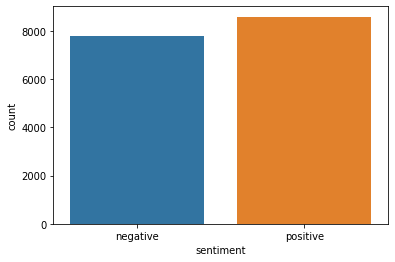

In [ ]:
# Summarise sentiment details in a data visualisation format
sns.countplot(x=Tw_train['sentiment'])

As we can see in the above output, there are 16,363 rows or reviews in this dataset.

The data set consists of 3 columns,
- id - Autogenerated incrementing number as row Id
- Tweets - Tweets from Users
- sentiment - Label for sentiment (positive, negative)

# Data cleaning

If there are any missing values in the data set, corresponding entries need to be removed, because we cannot apply any preprocessing on them or use them for the model. 

The data set has 16,363 entries. So, it is a tedious task to check each row to find whether there is any missing value. 

In [ ]:
# drop the rows where at least one element is missing
Tw_train = Tw_train.dropna()

print(f'Number of train data entries: {len(Tw_train)}')

Number of train data entries: 16363


Number of entries in the cleaned data set is similar to the number of entries in the original data set. That means there were NO MISSING VALUE no missing values in our data set.

In [ ]:
#Checking for null values
Tw_train.isna().sum()

id           0
Tweets       0
sentiment    0
dtype: int64

In [ ]:
#Check duplicated content within the dataset
Tw_train.duplicated()


0        False
1        False
2        False
3        False
4        False
         ...  
16358    False
16359    False
16360    False
16361    False
16362    False
Length: 16363, dtype: bool

In [ ]:
Tw_train.duplicated().sum()

0

In [ ]:
Tw_train.describe()

,id,Tweets,sentiment
count,16363,16363,16363
unique,16363,16363,2
top,549e992a42,Sooo SAD I will miss you here in San Diego!!!,positive
freq,1,1,8582


In [ ]:
Tw_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16363 entries, 0 to 16362
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         16363 non-null  object
 1   Tweets     16363 non-null  object
 2   sentiment  16363 non-null  object
dtypes: object(3)
memory usage: 511.3+ KB


# Data preprocessing

As data preprocessing techniques, we learned following.
- Tokenisation
- text normalisation (lower casing, stemming and lemmatisation)
- Stop word removal
- Punctuation removal

Let's go through each step and apply it to the data set, if it is necessary or important to the targeted problem.


## Tokenisation

The first thing to do with tokenisation is selecting a tokenizer model. 

Under text Preprocessing, we learned about 2 tokenizers as follows.
- *word_tokenize* - Tokenizer for normal text
- *TweetTokenizer* - Tokenizer for Tweets

In this data set, we have normal text. Then we can use <i>TweetTokenizer</i>.

In [ ]:
# # # iterate through each row in 'Text' columm and convert text to tokens
# # list_tokenised_text = [TweetTokenizer(text) for text in Tw_train['text']]
# # print(list_tokenised_text[:2])

# tk = TweetTokenizer()
# Tweet_tokens = []
# for text in Tw_train:
#     print(tk.tokenize('text'))
#     Tweet_tokens.append(tk.tokenize('text'))

In [ ]:
# iterate through each row in 'Tweets' columm and convert Tweets to tokens
tknzr = TweetTokenizer()

train_list_tokenised_Tweet = [tknzr.tokenize(text) for text in Tw_train['Tweets']]
print(train_list_tokenised_Tweet[:2] )


[['Sooo', 'SAD', 'I', 'will', 'miss', 'you', 'here', 'in', 'San', 'Diego', '!', '!', '!'], ['my', 'boss', 'is', 'bullying', 'me', '...']]


In [ ]:
join_list_tokenised_sentences = [' '.join(tokens) for tokens in train_list_tokenised_Tweet]
print(join_list_tokenised_sentences[:2])

['Sooo SAD I will miss you here in San Diego ! ! !', 'my boss is bullying me ...']


In [ ]:
# add new column to data frame
Tw_train['Tokenised_Tweets'] = join_list_tokenised_sentences
Tw_train.head()

,id,Tweets,sentiment,Tokenised_Tweets
0,549e992a42,Sooo SAD I will miss you here in San Diego!!!,negative,Sooo SAD I will miss you here in San Diego ! ! !
1,088c60f138,my boss is bullying me...,negative,my boss is bullying me ...
2,9642c003ef,what interview! leave me alone,negative,what interview ! leave me alone
3,358bd9e861,"Sons of ****, why couldn`t they put them on t...",negative,"Sons of * * * , why couldn ` t they put them o..."
4,6e0c6d75b1,2am feedings for the baby are fun when he is a...,positive,2am feedings for the baby are fun when he is a...


In [ ]:
Tw_train.tail()

,id,Tweets,sentiment,Tokenised_Tweets
16358,b78ec00df5,enjoy ur night,positive,enjoy ur night
16359,4eac33d1c0,wish we could come see u on Denver husband l...,negative,wish we could come see u on Denver husband los...
16360,4f4c4fc327,I`ve wondered about rake to. The client has ...,negative,I ` ve wondered about rake to . The client has...
16361,f67aae2310,Yay good for both of you. Enjoy the break - y...,positive,Yay good for both of you . Enjoy the break - y...
16362,ed167662a5,But it was worth it ****.,positive,But it was worth it * * * .


Analysing some features within TweetTokenizer for accurate tokenization

In [ ]:
# make the tokens case insensitive, reduce length and remove usernames
print('\nconfigs: preserve_case=False, reduce_len=True, strip_handles=True')
tknzr = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True)

train_list_tokenised_Tweet = [tknzr.tokenize (text) for text in Tw_train['Tweets']]
print(train_list_tokenised_Tweet[:2])


configs: preserve_case=False, reduce_len=True, strip_handles=True
[['sooo', 'sad', 'i', 'will', 'miss', 'you', 'here', 'in', 'san', 'diego', '!', '!', '!'], ['my', 'boss', 'is', 'bullying', 'me', '...']]


## Text normalisation
Lower casing

Lower casing has been done from the preserve_case=False option above






















































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































In [ ]:
# lower_cased_tweet = train_list_tokenised_Tweet.lower()
# print(lower_cased_tweet)

 Stemming

In [ ]:
ps = PorterStemmer()

stem_words = [ps.stem(word) for word in Tw_train['Tokenised_Tweets']]
print(f'Stemmed sentences: {stem_words}\n')


Stemmed sentences: ['sooo sad i will miss you here in san diego ! ! !', 'my boss is bullying me ...', 'what interview ! leave me alon', 'sons of * * * , why couldn ` t they put them on the releases we already bought', '2am feedings for the baby are fun when he is all smiles and coo', 'journey ! ? wow ... u just became cooler . hehe ... ( is that possible ! ? )', 'i really really like the song love story by taylor swift', 'my sharpie is running dangerously low on ink', 'i want to go to music tonight but i lost my voice .', 'uh oh , i am sunburn', 's ` ok , trying to plot alternatives as we speak * sigh *', 'i ` ve been sick for the past few days and thus , my hair looks wierd . if i didnt have a hat on it would look ... http://tinyurl.com/mnf4kw', 'is back home now gonna miss every on', 'playing ghost online is really interesting . the new updates are kirin pet and metamorph for third job . can ` t wait to have a dragon pet', 'the free fillin ` app on my ipod is fun , im addict', 'i ` m

In [ ]:
# # add new column to data frame

# train_list_stemmed_sentences = [stem_words]

# Tw_train['Stemmed_Text'] = train_list_stemmed_sentences

# Tw_train.head()

 Lemmatisation

 Lemmatisation is the more organised procedure.

In [ ]:
#LEMMATISATION OF THE TEST DATA

wnl = WordNetLemmatizer()

train_list_lemmatised_sentences = []

# iterate through each list of tokens and lemmatise the tokens
for tokens in train_list_tokenised_Tweet:
  lemma_words = [wnl.lemmatize(word) for word in tokens]
  lemma_sentence = ' '.join(lemma_words)
  train_list_lemmatised_sentences.append(lemma_sentence)
  
print(train_list_lemmatised_sentences[:2])

# add new column to data frame
Tw_train['Lemmatised_Tweets'] = train_list_lemmatised_sentences

Tw_train.head()

['sooo sad i will miss you here in san diego ! ! !', 'my bos is bullying me ...']


,id,Tweets,sentiment,Tokenised_Tweets,Lemmatised_Tweets
0,549e992a42,Sooo SAD I will miss you here in San Diego!!!,negative,Sooo SAD I will miss you here in San Diego ! ! !,sooo sad i will miss you here in san diego ! ! !
1,088c60f138,my boss is bullying me...,negative,my boss is bullying me ...,my bos is bullying me ...
2,9642c003ef,what interview! leave me alone,negative,what interview ! leave me alone,what interview ! leave me alone
3,358bd9e861,"Sons of ****, why couldn`t they put them on t...",negative,"Sons of * * * , why couldn ` t they put them o...","son of * * * , why couldn ` t they put them on..."
4,6e0c6d75b1,2am feedings for the baby are fun when he is a...,positive,2am feedings for the baby are fun when he is a...,2am feeding for the baby are fun when he is al...


In [ ]:
# # save updated data frame to a file
# # This step is optional for the main flow. But by saving data to a file you can analyse the preprocessed text output more deeply. 

# Tw_train.to_csv('/content/Tweets_new.csv', index=False)

# Tw_train.head()

## Stop word removal
English stop words

In [ ]:
# get English stopwords
english_stopwords = set(stopwords.words('english')) 
print(english_stopwords)

train = pd.DataFrame(Tw_train)
train.columns = ["id", "Tweets", "sentiment","Tokenised_Tweets", "Lemmatised_Tweets"]

# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
train['Tweet_without_stopwords'] = train['Tweets'].apply(lambda x: ' '.join([word for word in x.split() if word not in (english_stopwords)]))
print(train)

{'from', 'up', "hadn't", 't', 'at', 'me', 'or', 'here', 'don', 'how', 'o', 'nor', 'it', 'why', 'for', 'above', 'under', 'all', 'do', 'out', "that'll", 'both', "isn't", 'between', "you're", 'itself', 'his', 'hers', 'this', 'aren', 'is', "she's", 'them', 'did', 'and', 'didn', 'mustn', "you'd", 'a', 'll', 'ourselves', 'our', 'my', 'haven', 'below', 'when', 'where', 'after', 'has', 'him', 'there', "mustn't", 'each', 'on', 'that', 'hadn', 'while', 'these', 'we', "you'll", 'in', 'have', 'to', 'which', 'until', 'own', 'their', 'myself', 's', 'no', "it's", "wouldn't", 'not', 'should', 'be', 'been', 'once', 'ain', 'your', "you've", 'they', 'any', 'needn', 'then', 'during', "won't", 'shan', 'ours', 'yourself', 'won', 'again', 'what', 'yours', 'too', 'as', "shan't", 'having', 'couldn', "hasn't", 'those', 'with', 'more', 'were', 'before', 'ma', 'can', 'mightn', 'into', 'y', 'just', 'against', 'its', 'other', 'you', 'who', 'she', 'themselves', 'because', 'whom', 'such', 'am', 'by', 'over', "mightn'

Although I was able to remove some Stop word, but vectorizers can be used to take them out

In [ ]:
# doc = nlp()
# print([token.lemma_ for token in doc])

## Punctuation removal

To convert text into numeric features, we use vectorizers (CountVectorizer, TfiTw_trainVectorizer). As we already learned, punctuation removal can be easily handled with the vectorizer. Thus, no any preprocessing step is needed.

In [ ]:
# print(f'Punctuation marks: {string.punctuation}\n')

# # remove puncuation marks in dataset
# table = str.maketrans(dict.fromkeys(string.punctuation))
# no_punctuation= Tw_train.translate(table)

# print(no_punctuation)

## Summary
We went through all text preprocessing steps, discussed their appropriateness  and applied them to the data set.

In summary, now we have a data frame named <i>Tw_train</i> with following columns.
- 'Id' - Ids
- 'Tweets' - original text data
- 'sentiment' - labels
- 'Tokenised_text' - tokenised text
- 'Lemmatised_text' - lemmatised text
- Tweet_without_stopwords - Tweets with no stopwords

# Text feature extraction and model generation

We can convert text into numeric features using term occurrence vectors or tf-idf vectors. This conversion can be easily done using CountVectorizer or TfidfVectorizer.

As classification algorithms, you learned Decision trees, SVM, and Naive Bayes under Machine Learning module.


Looking at available data preprocessing techniques and features, we can make different combinations to tryout different models.

To make things clear, I am using lower casing and punctuation removal as default preprocessing steps and any changes other than that are mentioned in the table. 

Initially we will compare the performance of  term occurrence vectors and tf-idf vectors. Then the best vector representation will be used with other data preprocessing techniques. 

Let's follow these combinations and check their impact on model accuracy.

<b>NOTE!</b> All combinations are not listed here.

As the first step, we need to separate data into a training set and validation set.

In [ ]:
# use raw text
X_train_text, X_val_text, y_train, y_val = train_test_split(Tw_train['Tweets'], Tw_train['sentiment'], test_size=0.3, random_state=RANDOM_SEED)
print(f'training data set size: {len(X_train_text)}')
print(f'validation data set size: {len(X_val_text)}')

# use tokenised text
X_train_tokenised_text, X_val_tokenised_text, y_train, y_val = train_test_split(Tw_train['Tokenised_Tweets'], Tw_train['sentiment'], test_size=0.3, random_state=RANDOM_SEED)
print(f'training data set size: {len(X_train_tokenised_text)}')
print(f'validation data set size: {len(X_val_tokenised_text)}')

# use lemmatised text
X_train_lemmatised_text, X_val_lemmatised_text, y_train, y_val = train_test_split(Tw_train['Lemmatised_Tweets'], Tw_train['sentiment'], test_size=0.3, random_state=RANDOM_SEED)
print(f'training data set size: {len(X_train_lemmatised_text)}')
print(f'validation data set size: {len(X_val_lemmatised_text)}')

# define class_names to using with plot_confusion_matrix
class_list = ['positive', 'negative']

training data set size: 11454
validation data set size: 4909
training data set size: 11454
validation data set size: 4909
training data set size: 11454
validation data set size: 4909


In [ ]:
# method to plot confusion matrix
def plot_confusion_matrix(matrix, class_names):
    plt.clf()
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Set2_r)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    s = [['TP','FP'], ['FN', 'TN']]

    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(matrix[i][j]))
    plt.show()


In [ ]:
# method to calculate evaluation results
def evaluate(actuals, predictions, class_names):
  accuracy = metrics.accuracy_score(actuals, predictions)
  confusion_matrix = metrics.confusion_matrix(actuals, predictions, labels=class_names)
  return accuracy, confusion_matrix

#Test Data Pre_processing and Wrangling

**REMEMBER!** Apply the same preprocessing techniques used with model's training data to test data.

In [ ]:
# loading the test data set

# As the parameter, the file path is provided below
Tw_test = pd.read_csv('/content/drive/MyDrive/AppliedAI/Assessment 2/test.csv')

Tw_test.head()

,id,text
0,96d74cb729,Shanghai is also really exciting (precisely -...
1,eee518ae67,"Recession hit Veronique Branquinho, she has to..."
2,01082688c6,happy bday!
3,33987a8ee5,http://twitpic.com/4w75p - I like it!!
4,726e501993,that`s great!! weee!! visitors!


In [ ]:
Tw_test.shape

(1000, 2)

In [ ]:
Tw_test.tail()

,id,text
995,9b210c4a6f,Haha...YAY!!! I`M CURED!!!!
996,68c674acdb,"Sick, sick, sick. This sucks. i can`t even bre..."
997,6cadda7b98,Adding names to my Twitter account and learnin...
998,79a28b1ac7,ooh thats an early start ive got bed planned...
999,05a1b09ce9,Booo my best friend is leavin for the weekend....


In [ ]:
Tw_test = Tw_test.rename(columns={'text':'Tweets'})
Tw_test

,id,Tweets
0,96d74cb729,Shanghai is also really exciting (precisely -...
1,eee518ae67,"Recession hit Veronique Branquinho, she has to..."
2,01082688c6,happy bday!
3,33987a8ee5,http://twitpic.com/4w75p - I like it!!
4,726e501993,that`s great!! weee!! visitors!
...,...,...
995,9b210c4a6f,Haha...YAY!!! I`M CURED!!!!
996,68c674acdb,"Sick, sick, sick. This sucks. i can`t even bre..."
997,6cadda7b98,Adding names to my Twitter account and learnin...
998,79a28b1ac7,ooh thats an early start ive got bed planned...


In [ ]:
# drop the rows where at least one element is missing
Tw_test = Tw_test.dropna()

print(f'Number of test entries: {len(Tw_test)}')

Number of test entries: 1000


In [ ]:
Tw_test.isna().sum()

id        0
Tweets    0
dtype: int64

In [ ]:
Tw_test.duplicated().sum()

0

In [ ]:
Tw_test.describe()

,id,Tweets
count,1000,1000
unique,1000,1000
top,96d74cb729,Shanghai is also really exciting (precisely -...
freq,1,1


In [ ]:
# iterate through each row in 'Tweets' columm and convert Tweets to tokens
tknzr = TweetTokenizer()

test_list_tokenised_Tweet = [tknzr.tokenize(text) for text in Tw_test['Tweets']]
print(test_list_tokenised_Tweet[:2] )


[['Shanghai', 'is', 'also', 'really', 'exciting', '(', 'precisely', '-', '-', 'skyscrapers', 'galore', ')', '.', 'Good', 'tweeps', 'in', 'China', ':', '(', 'SH', ')', '(', 'BJ', ')', '.'], ['Recession', 'hit', 'Veronique', 'Branquinho', ',', 'she', 'has', 'to', 'quit', 'her', 'company', ',', 'such', 'a', 'shame', '!']]


In [ ]:
test_list_tokenised_sentences = [' '.join(tokens) for tokens in test_list_tokenised_Tweet]
print(test_list_tokenised_sentences[:2])

['Shanghai is also really exciting ( precisely - - skyscrapers galore ) . Good tweeps in China : ( SH ) ( BJ ) .', 'Recession hit Veronique Branquinho , she has to quit her company , such a shame !']


In [ ]:
# add new column to data frame
Tw_test['Tokenised_Tweets'] = test_list_tokenised_sentences
Tw_test.head()

,id,Tweets,Tokenised_Tweets
0,96d74cb729,Shanghai is also really exciting (precisely -...,Shanghai is also really exciting ( precisely -...
1,eee518ae67,"Recession hit Veronique Branquinho, she has to...","Recession hit Veronique Branquinho , she has t..."
2,01082688c6,happy bday!,happy bday !
3,33987a8ee5,http://twitpic.com/4w75p - I like it!!,http://twitpic.com/4w75p - I like it ! !
4,726e501993,that`s great!! weee!! visitors!,that ` s great ! ! weee ! ! visitors !


In [ ]:
Tw_test.tail()

,id,Tweets,Tokenised_Tweets
995,9b210c4a6f,Haha...YAY!!! I`M CURED!!!!,Haha ... YAY ! ! ! I ` M CURED ! ! !
996,68c674acdb,"Sick, sick, sick. This sucks. i can`t even bre...","Sick , sick , sick . This sucks . i can ` t ev..."
997,6cadda7b98,Adding names to my Twitter account and learnin...,Adding names to my Twitter account and learnin...
998,79a28b1ac7,ooh thats an early start ive got bed planned...,ooh thats an early start ive got bed planned f...
999,05a1b09ce9,Booo my best friend is leavin for the weekend....,Booo my best friend is leavin for the weekend ...


Stemming

In [ ]:
ps = PorterStemmer()

test_stem_words = [ps.stem(word) for word in Tw_test['Tokenised_Tweets']]
print(f'Stemmed sentences: {test_stem_words}\n')


Stemmed sentences: ['shanghai is also really exciting ( precisely - - skyscrapers galore ) . good tweeps in china : ( sh ) ( bj ) .', 'recession hit veronique branquinho , she has to quit her company , such a shame !', 'happy bday !', 'http://twitpic.com/4w75p - i like it ! !', 'that ` s great ! ! weee ! ! visitors !', 'i think everyone hates me on here lol', 'soooooo wish i could , but im in school and myspace is completely block', 'my bike was put on hold ... should have known that ... argh total bumm', 'i ` m in va for the weekend , my youngest son turns 2 tomorrow ... it makes me kinda sad , he is getting so big , check out my twip', 'its coming out the socket i feel like my phones hole is not a virgin . that ` s how loose it is ... : ` (', 'so hot today = _ = don ` t like it and i hate my new timetable , having such a bad week', 'miss you', 'cramps . . .', 'you guys didn ` t say hi or answer my questions yesterday but nice songs .', 'stupid storm . no river for us tonight', 'my de

Lemmatisation

In [ ]:
#LEMMATISATION OF THE TEST DATA

wnl = WordNetLemmatizer()

test_list_lemmatised_sentences = []

# iterate through each list of tokens and lemmatise the tokens
for tokens in test_list_tokenised_Tweet:
  lemma_words = [wnl.lemmatize(word) for word in tokens]
  lemma_sentence = ' '.join(lemma_words)
  test_list_lemmatised_sentences.append(lemma_sentence)
  
print(test_list_lemmatised_sentences[:2])

# add new column to data frame
Tw_test['Lemmatised_Tweets'] = test_list_lemmatised_sentences

Tw_test.head()

['Shanghai is also really exciting ( precisely - - skyscraper galore ) . Good tweeps in China : ( SH ) ( BJ ) .', 'Recession hit Veronique Branquinho , she ha to quit her company , such a shame !']


,id,Tweets,Tokenised_Tweets,Lemmatised_Tweets
0,96d74cb729,Shanghai is also really exciting (precisely -...,Shanghai is also really exciting ( precisely -...,Shanghai is also really exciting ( precisely -...
1,eee518ae67,"Recession hit Veronique Branquinho, she has to...","Recession hit Veronique Branquinho , she has t...","Recession hit Veronique Branquinho , she ha to..."
2,01082688c6,happy bday!,happy bday !,happy bday !
3,33987a8ee5,http://twitpic.com/4w75p - I like it!!,http://twitpic.com/4w75p - I like it ! !,http://twitpic.com/4w75p - I like it ! !
4,726e501993,that`s great!! weee!! visitors!,that ` s great ! ! weee ! ! visitors !,that ` s great ! ! weee ! ! visitor !


#Removing stopwords from Test dataset

In [ ]:
# get English stopwords
english_stopwords = set(stopwords.words('english')) 
print(english_stopwords)

test = pd.DataFrame(Tw_test)
test.columns = ["id", "Tweets","Tokenised_Tweets", "Lemmatised_Tweets"]

# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
test['Tweet_without_stopwords'] = test['Tweets'].apply(lambda x: ' '.join([word for word in x.split() if word not in (english_stopwords)]))
print(test)

{'from', 'up', "hadn't", 't', 'at', 'me', 'or', 'here', 'don', 'how', 'o', 'nor', 'it', 'why', 'for', 'above', 'under', 'all', 'do', 'out', "that'll", 'both', "isn't", 'between', "you're", 'itself', 'his', 'hers', 'this', 'aren', 'is', "she's", 'them', 'did', 'and', 'didn', 'mustn', "you'd", 'a', 'll', 'ourselves', 'our', 'my', 'haven', 'below', 'when', 'where', 'after', 'has', 'him', 'there', "mustn't", 'each', 'on', 'that', 'hadn', 'while', 'these', 'we', "you'll", 'in', 'have', 'to', 'which', 'until', 'own', 'their', 'myself', 's', 'no', "it's", "wouldn't", 'not', 'should', 'be', 'been', 'once', 'ain', 'your', "you've", 'they', 'any', 'needn', 'then', 'during', "won't", 'shan', 'ours', 'yourself', 'won', 'again', 'what', 'yours', 'too', 'as', "shan't", 'having', 'couldn', "hasn't", 'those', 'with', 'more', 'were', 'before', 'ma', 'can', 'mightn', 'into', 'y', 'just', 'against', 'its', 'other', 'you', 'who', 'she', 'themselves', 'because', 'whom', 'such', 'am', 'by', 'over', "mightn'

### USING Model 1 - DECISION TREE

In [ ]:
# method to train and predict using Decision Tree
def get_tree_predictions(X_train, X_val, y_train, y_val, class_list):
  # build model
  clf = tree.DecisionTreeClassifier(random_state=RANDOM_SEED)
  clf.fit(X_train, y_train)

  # Make predictions on test data
  y_pred = clf.predict(X_val)

  # evaluation
  accuracy, confusion_matrix = evaluate(y_val, y_pred, class_list)
  print(f'Accuracy: {accuracy}')
  plot_confusion_matrix(confusion_matrix, class_list)

  return clf

M1 - DT

Accuracy: 0.8056630678345895


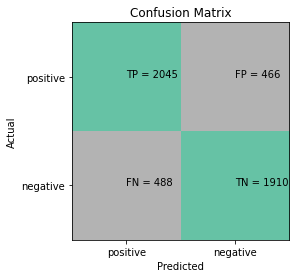

In [ ]:
 # default: lowercase=True, ngram_range=(1,1)
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train_text)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_text)
X_val = vectorizer.transform(X_val_text)

M1 = get_tree_predictions(X_train, X_val, y_train, y_val, class_list)

M2 - DT

Accuracy: 0.8022000407414952


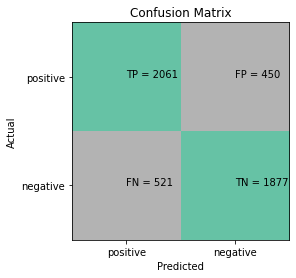

In [ ]:
#lowercase=True, ngram_range=(1,2)
vectorizer = TfidfVectorizer(ngram_range=(1,2))  
vectorizer.fit(X_train_tokenised_text)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_tokenised_text)
X_val = vectorizer.transform(X_val_text)

M2 = get_tree_predictions(X_train, X_val, y_train, y_val, class_list)

M3 - DT

Accuracy: 0.8036259930739458


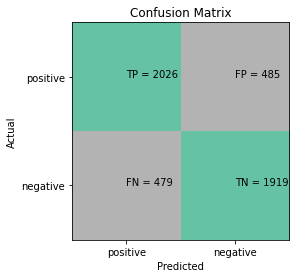

In [ ]:
# default: lowercase=True, ngram_range=(1,1)
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train_tokenised_text)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_tokenised_text)
X_val = vectorizer.transform(X_val_tokenised_text)

M3 = get_tree_predictions(X_train, X_val, y_train, y_val, class_list)

M4 - DT

Accuracy: 0.7979221837441434


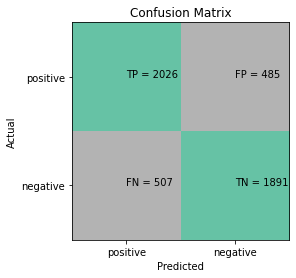

In [ ]:
# default: lowercase=True, ngram_range=(1,1)
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train_lemmatised_text)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_lemmatised_text)
X_val = vectorizer.transform(X_val_lemmatised_text)

M4 = get_tree_predictions(X_train, X_val, y_train, y_val, class_list)

M5 - DT

Accuracy: 0.8072927276431046


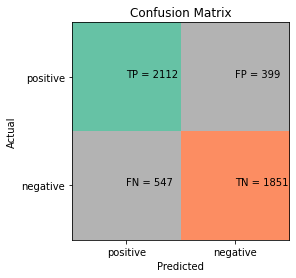

In [ ]:
#lowercase=True, ngram_range=(1,1)
vectorizer11 = TfidfVectorizer(stop_words=english_stopwords)
vectorizer11.fit(X_train_tokenised_text)

# convert train and test text data to numeric vectors
X_train = vectorizer11.transform(X_train_tokenised_text)
X_val = vectorizer11.transform(X_val_tokenised_text)

M5 = get_tree_predictions(X_train, X_val, y_train, y_val, class_list)

M6 - DT

Accuracy: 0.7948665716031779


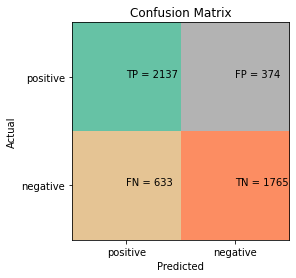

In [ ]:
#lowercase=True, ngram_range=(1,2), stopword removed
vectorizer11 = TfidfVectorizer(stop_words=english_stopwords, ngram_range=(1,2))
vectorizer11.fit(X_train_tokenised_text)

# convert train and test text data to numeric vectors
X_train = vectorizer11.transform(X_train_tokenised_text)
X_val = vectorizer11.transform(X_val_tokenised_text)

M6 = get_tree_predictions(X_train, X_val, y_train, y_val, class_list)

M7 - DT

Accuracy: 0.8022000407414952


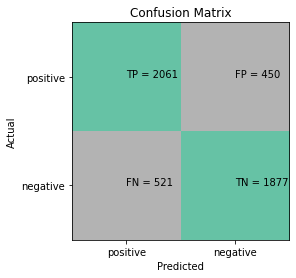

In [ ]:
# lowercase=True, ngram_range=(1,2)
vectorizer11 = TfidfVectorizer(ngram_range=(1,2))
vectorizer11.fit(X_train_tokenised_text)

# convert train and test text data to numeric vectors
X_train = vectorizer11.transform(X_train_tokenised_text)
X_val = vectorizer11.transform(X_val_tokenised_text)

M7 = get_tree_predictions(X_train, X_val, y_train, y_val, class_list)

Best accuracy so far obtained by this model is M5. As seen below, stop word removal has an increase the accuracy of the model for this data. 

### **Summary**
Based on our finding up to now, the above tables can be updated to following version.

|Model | Data Preprocessing | Features   |Accuracy|
|------|--------------------|------------|--------|
|M1    |-| term occurrence vector(1-grams) | 0.8056 |
|M2    |tokenisation(NLTK)| tf-idf vector(1-grams) | 0.8022 |
|M3    |tokenisation(NLTK) | tf-idf vector(1-grams) | 0.8036 |
|M4    |lemmatisation(WordNet) | tf-idf vector(1-grams) | 0.7979 |
|M5   |tokenisation(NLTK), stop word removal | tf-idf vector(1-grams) | 0.8072 |
| M6   | tokenisation (NLTK, stopword removal| tf-idf vector(1, 2grams) | 0.7948
|M7  | tokenisation |  tf-idf vector(1, 2 grams) | 0.8022

### USING Model 2 - NAIVE BAYES

In [ ]:
# method to train and predict using Naive Bayes
def get_gnb_predictions(X_train, X_val, y_train, y_val, class_list):
  
  # build model
  clf = MultinomialNB()
  clf.fit(X_train, y_train)

  # # build model
  # clf = GaussianNB()
  # clf.fit(X_train, y_train)

  # Make predictions on test data
  y_pred = clf.predict(X_val)

  # evalution
  accuracy, confusion_matrix = evaluate(y_val, y_pred, class_list)
  print(f'Accuracy: {accuracy}')
  plot_confusion_matrix(confusion_matrix, class_list)

  return clf

M8 - NB

Accuracy: 0.8529232022815237


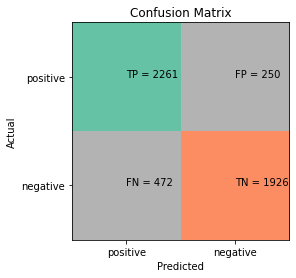

In [ ]:
# default: lowercase=True, ngram_range=(1,1)
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train_tokenised_text)

# convert train and test tweet data to numeric vectors
X_train = vectorizer.transform(X_train_tokenised_text)
X_val = vectorizer.transform(X_val_text)

M8 = get_gnb_predictions(X_train, X_val, y_train, y_val, class_list)

M9 - NB

Accuracy: 0.8521083723772662


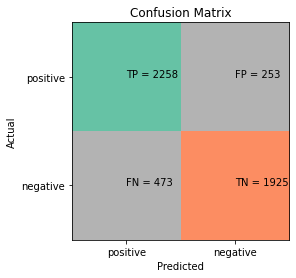

In [ ]:
# default: lowercase=True, ngram_range=(1,1)
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train_text)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_text)
X_val = vectorizer.transform(X_val_text)

M9 = get_gnb_predictions(X_train, X_val, y_train, y_val, class_list)

M10 - NB

Accuracy: 0.8533306172336524


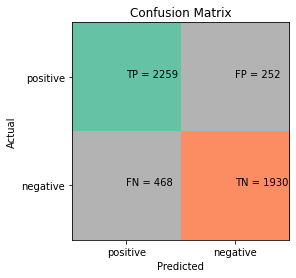

In [ ]:
# default: lowercase=True, ngram_range=(1,1)
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train_lemmatised_text)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_lemmatised_text)
X_val = vectorizer.transform(X_val_tokenised_text)

M10 = get_gnb_predictions(X_train, X_val, y_train, y_val, class_list)

M11 - NB

Accuracy: 0.8590344265634549


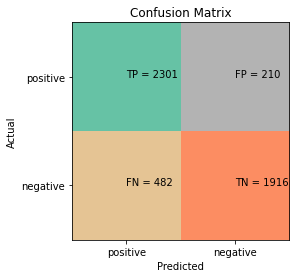

In [ ]:
#lowercase=True, ngram_range=(1,2)
vectorizer = TfidfVectorizer(ngram_range=(1,2))
vectorizer.fit(X_train_lemmatised_text)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_lemmatised_text)
X_val = vectorizer.transform(X_val_lemmatised_text)

M11 = get_gnb_predictions(X_train, X_val, y_train, y_val, class_list)

M12 - NB

Accuracy: 0.8512935424730088


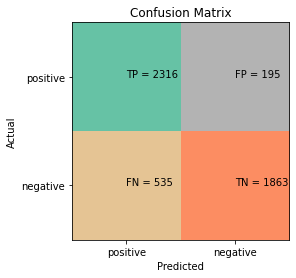

In [ ]:
#lowercase=True, ngram_range=(1,3)
vectorizer = TfidfVectorizer(ngram_range=(1,3))
vectorizer.fit(X_train_lemmatised_text)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_lemmatised_text)
X_val = vectorizer.transform(X_val_lemmatised_text)

M12 = get_gnb_predictions(X_train, X_val, y_train, y_val, class_list)

M13 - NB

Accuracy: 0.8527194948054594


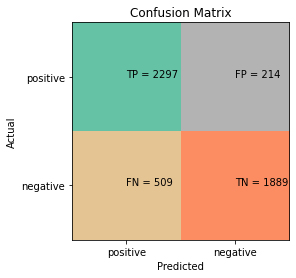

In [ ]:
#lowercase=True, ngram_range=(1,2)
vectorizer = TfidfVectorizer(ngram_range=(1,2)) 
vectorizer.fit(X_train_tokenised_text)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_tokenised_text)
X_val = vectorizer.transform(X_val_lemmatised_text)

M13 = get_gnb_predictions(X_train, X_val, y_train, y_val, class_list)

M14 - NB

Accuracy: 0.8547565695661031


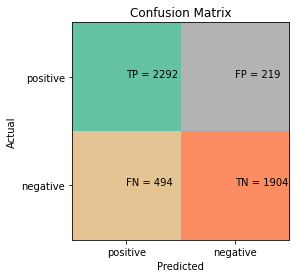

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))  # default: lowercase=True, ngram_range=(1,1)
vectorizer.fit(X_train_lemmatised_text)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_tokenised_text)
X_val = vectorizer.transform(X_val_lemmatised_text)

M14 = get_gnb_predictions(X_train, X_val, y_train, y_val, class_list)

The best model for Naive Bayes is M11 seen below

### Summary
Based on our finding up to now, the above tables can be updated to following version.

|Model | Data Preprocessing | Features   |Accuracy|
|------|--------------------|------------|--------|
|M8  | tokenisation(NLTK) | tf-idf vector(1-grams) | 0.8529 |
|M9    |- | tf-idf vector(1-grams) | 0.8521 |
|M10    |lemmatisation(WordNet) | tf-idf vector(1-grams) | 0.8533 |
|M11    |lemmatisation(WordNet) | tf-idf vector(1 , 2grams) | 0.8590 |
|M12 | lemmatisation(WordNet)| tf-idf vector(1 , 3grams) | 0.8512 |
|M13 | tokenisation(NLTK) | tf-idf vector(1,2grams) | 0.8527|
|M14 | lemmatisation(WordNet) | tf-idf vector(1,2grams)| 0.8547 |

###MODEL 3 - SUPPORT VECTOR MACHINE

In [ ]:
# method to train and predict using SVM classifier
def get_svm_predictions(X_train, X_val, y_train, y_val, class_names):
  # build model
  clf = svm.SVC(kernel='linear', random_state=RANDOM_SEED) 
  clf.fit(X_train, y_train)

    # Make predictions on test data
  y_pred = clf.predict(X_val)

   # evalution
  accuracy, confusion_matrix = evaluate(y_val, y_pred, class_names)
  print(f'Accuracy: {accuracy}')
  plot_confusion_matrix(confusion_matrix, class_names)

  return clf


M15 - SVM

Accuracy: 0.8602566714198411


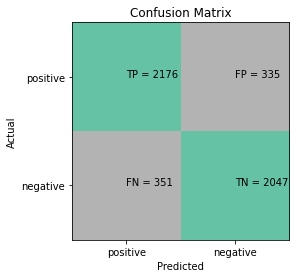

In [ ]:
vectorizer = CountVectorizer()  # default: lowercase=True, ngram_range=(1,1)
vectorizer.fit(X_train_text)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_text)
X_val = vectorizer.transform(X_val_text)

m1 = get_svm_predictions(X_train, X_val, y_train, y_val, class_list)

M16 - SVM

Accuracy: 0.870034630270931


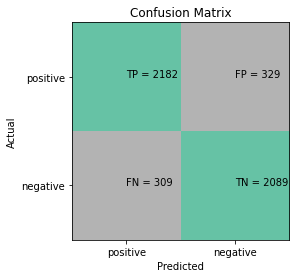

In [ ]:
vectorizer3 = TfidfVectorizer()  # default: lowercase=True, ngram_range=(1,1)
vectorizer3.fit(X_train_tokenised_text)

# convert train and test text data to numeric vectors
X_train = vectorizer3.transform(X_train_tokenised_text)
X_val = vectorizer3.transform(X_val_tokenised_text)

M16 = get_svm_predictions(X_train, X_val, y_train, y_val, class_list)

M17 - SVM

Accuracy: 0.8716642900794459


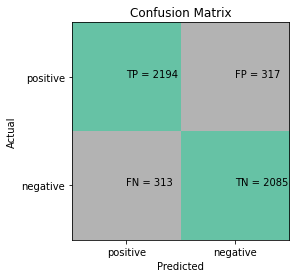

In [ ]:
vectorizer = TfidfVectorizer()  # default: lowercase=True, ngram_range=(1,1)
vectorizer.fit(X_train_lemmatised_text)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_lemmatised_text)
X_val = vectorizer.transform(X_val_lemmatised_text)

M17 = get_svm_predictions(X_train, X_val, y_train, y_val, class_list)

M18 - SVM

Accuracy: 0.8584233041352618


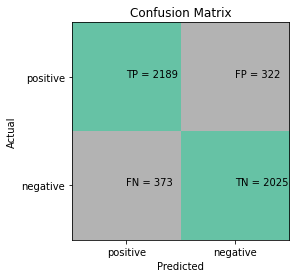

In [ ]:
vectorizer = TfidfVectorizer(stop_words=english_stopwords)  # default: lowercase=True, ngram_range=(1,1)
vectorizer.fit(X_train_tokenised_text)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_tokenised_text)
X_val = vectorizer.transform(X_val_tokenised_text)

M18 = get_svm_predictions(X_train, X_val, y_train, y_val, class_list)

M19 -SVM

Accuracy: 0.8741087797922183


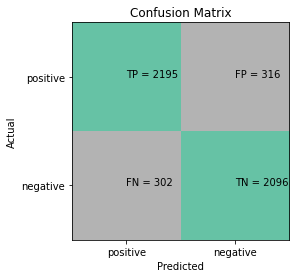

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))  # default: lowercase=True, ngram_range=(1,2)
vectorizer.fit(X_train_tokenised_text)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_tokenised_text)
X_val = vectorizer.transform(X_val_tokenised_text)

M19 = get_svm_predictions(X_train, X_val, y_train, y_val, class_list)

M20A - SVM

Accuracy: 0.8539417396618456


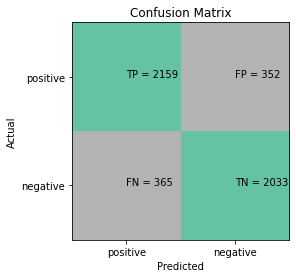

In [ ]:
vectorizer = TfidfVectorizer(stop_words=english_stopwords)  # default: lowercase=True, ngram_range=(1,1)
vectorizer.fit(X_train_lemmatised_text)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_tokenised_text)
X_val = vectorizer.transform(X_val_tokenised_text)

M20A = get_svm_predictions(X_train, X_val, y_train, y_val, class_list)

In [ ]:
#Viewing dataset o see what stopword to create variable for and remove
X_train_lemmatised_text[:20]

4585     is wishing everyone a blessed & beautiful moth...
11427    traffic is horrific on 695 .. i jus wanna gt m...
3671     grrh my phone ( brand new might i add ) keep j...
4315                     take me with you ! ! ! have fun !
6356                                    i hate being young
505                       goodnight magic and pretty world
12727    thankyou short stack for bringing out a second...
12868    guy . just got someone with saran wrap . tuesd...
3910     hapee mother ` s day t all the mother out there !
1907     _avenue love your website ! wish i lived close...
2276                                   hotness personified
1135     oh my god , i finally found someone online ! haha
1706     gotta go now .. i ` m going to circus .. the r...
12233    don ` t really wanna go school on monday to be...
10654    twit twit twitter ! trying to ' legally ' watc...
10292                     i wish i wa getting pancake booo
5388     doesn ` t wanna get dressed up and be an adult.

In [ ]:
#From above dataset viewing, I wish to add few stopwords
stop_words = ['wa', 'wanna','the','a']

M20B - SVM Without some stopwords

Accuracy: 0.8637196985129354


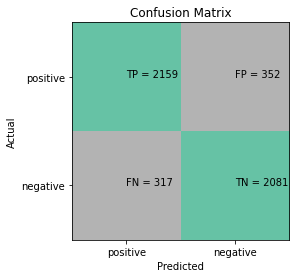

In [ ]:
vectorizer = TfidfVectorizer(stop_words=stop_words)  # default: lowercase=True, ngram_range=(1,1)
vectorizer.fit(X_train_lemmatised_text)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_tokenised_text)
X_val = vectorizer.transform(X_val_tokenised_text)

M20B = get_svm_predictions(X_train, X_val, y_train, y_val, class_list)

From above differences, M20B accuracy increased significantly due to some stopword removal from 0.853 to 0.863

M21 - SVM

Accuracy: 0.8690160928906091


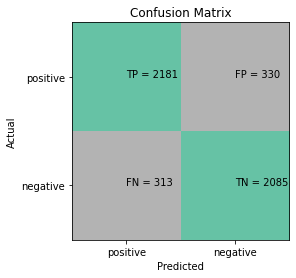

In [ ]:

vectorizer = TfidfVectorizer()  # default: lowercase=True, ngram_range=(1,2)
vectorizer.fit(X_train_text)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_text)
X_val = vectorizer.transform(X_val_text)

M21 = get_svm_predictions(X_train, X_val, y_train, y_val, class_list)

M22 - SVM

Accuracy: 0.8741087797922183


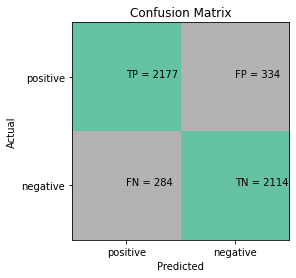

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))  # default: lowercase=True, ngram_range=(1,2)
vectorizer.fit(X_train_lemmatised_text)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_text)
X_val = vectorizer.transform(X_val_text)

M22 = get_svm_predictions(X_train, X_val, y_train, y_val, class_list)

M23 - SVM

Accuracy: 0.8557751069464249


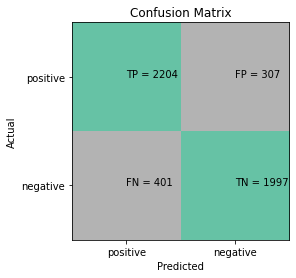

In [ ]:
vectorizer = TfidfVectorizer(stop_words=english_stopwords, ngram_range=(1,2))  # default: lowercase=True, ngram_range=(1,2)
vectorizer.fit(X_train_lemmatised_text)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_text)
X_val = vectorizer.transform(X_val_text)

M23 = get_svm_predictions(X_train, X_val, y_train, y_val, class_list)

M24 - SVM

Accuracy: 0.8624974536565492


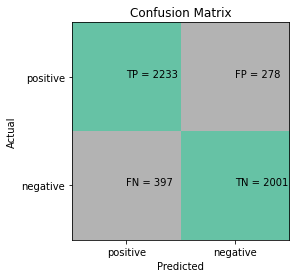

In [ ]:
vectorizer = TfidfVectorizer(stop_words=english_stopwords, ngram_range=(1,2))  # default: lowercase=True, ngram_range=(1,2)
vectorizer.fit(X_train_tokenised_text)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_text)
X_val = vectorizer.transform(X_val_text)

M24 = get_svm_predictions(X_train, X_val, y_train, y_val, class_list)

M25 - SVM

Accuracy: 0.8537380321857813


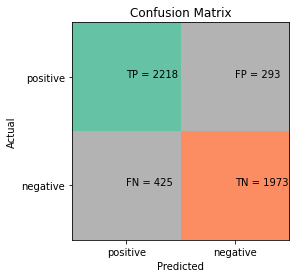

In [ ]:
vectorizer = TfidfVectorizer(stop_words=english_stopwords, ngram_range=(1,3))  # default: lowercase=True, ngram_range=(1,2)
vectorizer.fit(X_train_lemmatised_text)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_text)
X_val = vectorizer.transform(X_val_text)

M25 = get_svm_predictions(X_train, X_val, y_train, y_val, class_list)

We will stop here since we are not getting higher value at this point

According to the measures accuracy values below, Model M3 (SUPPORT VECTOR MACHINE) is giving more accuracy than model M1 Naive Bayes and M2 Decision Tree

### **Summary**
Based on our finding up to now, the above tables can be updated to following version.

|Model | Data Preprocessing | Features   |Accuracy|
|------|--------------------|------------|--------|
|M15    |-| term occurrence vector(1-grams) | 0.8602 |
|M16   |-| tf-idf vector(1-grams) | 0.8700 |
|M17   |lemmatisation(WordNet) | tf-idf vector(1-grams) | 0.8716 |
|M18  |tokenisation (NLTK), stopword removal | tf-idf vector(1-grams) | 0.8584 |
|M19  |tokenisation(NLTK) | tf-idf vector(2-grams) | 0.8741 |
|M20A |lemmatisation(WordNet), stopword removal | tf-idf vector(1-grams) | 0.8539 |
| M20B | lemmatisation(WordNet) | tf-idf vector(1-grams) | 0.8637 |
|M21 | - | tf-idf vector(1-grams) | 0.8690 |
|M22 | - | lemmatisation(WordNet) | tf-idf vector(2-grams) |0.8741 |
|M23 | - | lemmatisation(WordNet) stopword removal | tf-idf vector(2-grams) |0.8557 |
|M24 | - | tokenisation (NLTK), stopword | tf-idf vector(2-grams) |0.8624 |
|M25 | - | lemmatisation(WordNet) stopword removal | tf-idf vector(3-grams) |0.8537 |



Best accuracy so far is obtained by model M19 and M22. As seen, stop word removal did not increase the accuracy of model for this data.

# Predictions

In [ ]:
test_sentiment_analysis = Tw_test

test_sentiment_analysis.head()

,id,Tweets,Tokenised_Tweets,Lemmatised_Tweets,Tweet_without_stopwords
0,96d74cb729,Shanghai is also really exciting (precisely -...,Shanghai is also really exciting ( precisely -...,Shanghai is also really exciting ( precisely -...,Shanghai also really exciting (precisely -- sk...
1,eee518ae67,"Recession hit Veronique Branquinho, she has to...","Recession hit Veronique Branquinho , she has t...","Recession hit Veronique Branquinho , she ha to...","Recession hit Veronique Branquinho, quit compa..."
2,01082688c6,happy bday!,happy bday !,happy bday !,happy bday!
3,33987a8ee5,http://twitpic.com/4w75p - I like it!!,http://twitpic.com/4w75p - I like it ! !,http://twitpic.com/4w75p - I like it ! !,http://twitpic.com/4w75p - I like it!!
4,726e501993,that`s great!! weee!! visitors!,that ` s great ! ! weee ! ! visitors !,that ` s great ! ! weee ! ! visitor !,that`s great!! weee!! visitors!


Let's use the best model M22 - SVM we have created so far to make predictions for test data.

Accuracy: 0.8741087797922183


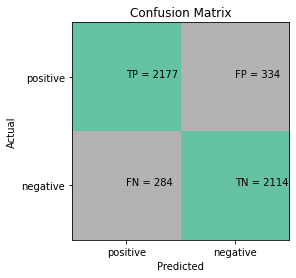

In [ ]:
vectorizer22 = TfidfVectorizer(ngram_range=(1,2))  # default: lowercase=True, ngram_range=(1,2)
vectorizer22.fit(X_train_lemmatised_text)

# convert train and test text data to numeric vectors
X_train = vectorizer22.transform(X_train_text)
X_val = vectorizer22.transform(X_val_text)

m22 = get_svm_predictions(X_train, X_val, y_train, y_val, class_list)

In [ ]:
X_test = vectorizer22.transform(test_sentiment_analysis['Lemmatised_Tweets'])
predictions = m22.predict(X_test)
print(predictions)

['positive' 'negative' 'positive' 'positive' 'positive' 'positive'
 'negative' 'negative' 'negative' 'negative' 'negative' 'negative'
 'negative' 'positive' 'negative' 'negative' 'negative' 'negative'
 'positive' 'positive' 'negative' 'positive' 'positive' 'negative'
 'negative' 'negative' 'negative' 'positive' 'positive' 'negative'
 'negative' 'negative' 'positive' 'positive' 'positive' 'negative'
 'negative' 'positive' 'negative' 'positive' 'positive' 'positive'
 'negative' 'negative' 'negative' 'positive' 'positive' 'positive'
 'positive' 'negative' 'negative' 'negative' 'positive' 'positive'
 'negative' 'positive' 'positive' 'negative' 'positive' 'negative'
 'positive' 'negative' 'positive' 'positive' 'negative' 'negative'
 'negative' 'positive' 'positive' 'positive' 'positive' 'positive'
 'negative' 'positive' 'positive' 'positive' 'negative' 'negative'
 'positive' 'positive' 'negative' 'positive' 'negative' 'negative'
 'positive' 'positive' 'negative' 'negative' 'negative' 'posit

In [ ]:
#We need to add the Sentiment prediction column to the new dataset

test_sentiment_analysis['prediction'] = predictions
test_sentiment_analysis.head()

,id,Tweets,Tokenised_Tweets,Lemmatised_Tweets,Tweet_without_stopwords,prediction
0,96d74cb729,Shanghai is also really exciting (precisely -...,Shanghai is also really exciting ( precisely -...,Shanghai is also really exciting ( precisely -...,Shanghai also really exciting (precisely -- sk...,positive
1,eee518ae67,"Recession hit Veronique Branquinho, she has to...","Recession hit Veronique Branquinho , she has t...","Recession hit Veronique Branquinho , she ha to...","Recession hit Veronique Branquinho, quit compa...",negative
2,01082688c6,happy bday!,happy bday !,happy bday !,happy bday!,positive
3,33987a8ee5,http://twitpic.com/4w75p - I like it!!,http://twitpic.com/4w75p - I like it ! !,http://twitpic.com/4w75p - I like it ! !,http://twitpic.com/4w75p - I like it!!,positive
4,726e501993,that`s great!! weee!! visitors!,that ` s great ! ! weee ! ! visitors !,that ` s great ! ! weee ! ! visitor !,that`s great!! weee!! visitors!,positive


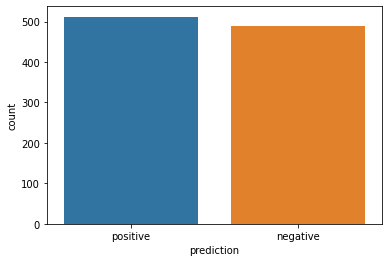

In [ ]:
# Summarise class details
sns.countplot(x=Tw_test['prediction'])

In [ ]:
test_sentiment_analysis.to_csv('/content/test_sentiment_analysis_Prediction.csv', index = False)
test_sentiment_analysis.head()

,id,Tweets,Tokenised_Tweets,Lemmatised_Tweets,Tweet_without_stopwords,prediction
0,96d74cb729,Shanghai is also really exciting (precisely -...,Shanghai is also really exciting ( precisely -...,Shanghai is also really exciting ( precisely -...,Shanghai also really exciting (precisely -- sk...,positive
1,eee518ae67,"Recession hit Veronique Branquinho, she has to...","Recession hit Veronique Branquinho , she has t...","Recession hit Veronique Branquinho , she ha to...","Recession hit Veronique Branquinho, quit compa...",negative
2,01082688c6,happy bday!,happy bday !,happy bday !,happy bday!,positive
3,33987a8ee5,http://twitpic.com/4w75p - I like it!!,http://twitpic.com/4w75p - I like it ! !,http://twitpic.com/4w75p - I like it ! !,http://twitpic.com/4w75p - I like it!!,positive
4,726e501993,that`s great!! weee!! visitors!,that ` s great ! ! weee ! ! visitors !,that ` s great ! ! weee ! ! visitor !,that`s great!! weee!! visitors!,positive


In [ ]:
# import json

# import pandas as pd

# test_file_path = "/content/test_sentiment_analysis_Prediction.csv"
# df_test = pd.read_csv(test_file_path)
# df_test = df_test[["id", "prediction"]]

# data = []
# for index, row in df_test.iterrows():
#     data.append({'id': row['id'], 'prediction': row['prediction']})

# print(data[0:5])

# submission_file_path = "submission.json"
# with open(submission_file_path, 'w') as fp:
#     fp.write('\n'.join(json.dumps(i) for i in data))

TEST VALIDATION USING M19

Accuracy: 0.8741087797922183


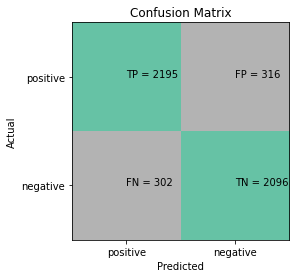

In [ ]:
vectorizer19 = TfidfVectorizer(ngram_range=(1,2))  # default: lowercase=True, ngram_range=(1,2)
vectorizer19.fit(X_train_tokenised_text)

# convert train and test text data to numeric vectors
X_train = vectorizer19.transform(X_train_tokenised_text)
X_val = vectorizer19.transform(X_val_tokenised_text)

m19 = get_svm_predictions(X_train, X_val, y_train, y_val, class_list)

In [ ]:
test_sentiment_analysis2 = Tw_test

test_sentiment_analysis2.head()

,id,Tweets,Tokenised_Tweets,Lemmatised_Tweets,Tweet_without_stopwords,prediction
0,96d74cb729,Shanghai is also really exciting (precisely -...,Shanghai is also really exciting ( precisely -...,Shanghai is also really exciting ( precisely -...,Shanghai also really exciting (precisely -- sk...,positive
1,eee518ae67,"Recession hit Veronique Branquinho, she has to...","Recession hit Veronique Branquinho , she has t...","Recession hit Veronique Branquinho , she ha to...","Recession hit Veronique Branquinho, quit compa...",negative
2,01082688c6,happy bday!,happy bday !,happy bday !,happy bday!,positive
3,33987a8ee5,http://twitpic.com/4w75p - I like it!!,http://twitpic.com/4w75p - I like it ! !,http://twitpic.com/4w75p - I like it ! !,http://twitpic.com/4w75p - I like it!!,positive
4,726e501993,that`s great!! weee!! visitors!,that ` s great ! ! weee ! ! visitors !,that ` s great ! ! weee ! ! visitor !,that`s great!! weee!! visitors!,positive


In [ ]:
X_test2 = vectorizer19.transform(test_sentiment_analysis2['Tokenised_Tweets'])
predictions_2 = m19.predict(X_test2)
print(predictions_2)

['positive' 'negative' 'positive' 'positive' 'positive' 'negative'
 'negative' 'negative' 'negative' 'negative' 'negative' 'negative'
 'negative' 'positive' 'negative' 'negative' 'negative' 'negative'
 'positive' 'positive' 'negative' 'positive' 'positive' 'negative'
 'negative' 'negative' 'negative' 'positive' 'positive' 'negative'
 'negative' 'negative' 'positive' 'positive' 'positive' 'negative'
 'negative' 'positive' 'negative' 'positive' 'positive' 'positive'
 'negative' 'negative' 'negative' 'positive' 'positive' 'positive'
 'positive' 'negative' 'negative' 'negative' 'positive' 'positive'
 'negative' 'positive' 'positive' 'negative' 'positive' 'negative'
 'positive' 'negative' 'positive' 'positive' 'negative' 'negative'
 'negative' 'positive' 'positive' 'positive' 'positive' 'negative'
 'negative' 'positive' 'positive' 'positive' 'negative' 'negative'
 'positive' 'positive' 'negative' 'positive' 'negative' 'negative'
 'positive' 'positive' 'negative' 'negative' 'negative' 'posit

In [ ]:
#We need to add the Sentiment prediction column to the new dataset

test_sentiment_analysis2['prediction'] = predictions_2
test_sentiment_analysis2.head()

,id,Tweets,Tokenised_Tweets,Lemmatised_Tweets,Tweet_without_stopwords,prediction
0,96d74cb729,Shanghai is also really exciting (precisely -...,Shanghai is also really exciting ( precisely -...,Shanghai is also really exciting ( precisely -...,Shanghai also really exciting (precisely -- sk...,positive
1,eee518ae67,"Recession hit Veronique Branquinho, she has to...","Recession hit Veronique Branquinho , she has t...","Recession hit Veronique Branquinho , she ha to...","Recession hit Veronique Branquinho, quit compa...",negative
2,01082688c6,happy bday!,happy bday !,happy bday !,happy bday!,positive
3,33987a8ee5,http://twitpic.com/4w75p - I like it!!,http://twitpic.com/4w75p - I like it ! !,http://twitpic.com/4w75p - I like it ! !,http://twitpic.com/4w75p - I like it!!,positive
4,726e501993,that`s great!! weee!! visitors!,that ` s great ! ! weee ! ! visitors !,that ` s great ! ! weee ! ! visitor !,that`s great!! weee!! visitors!,positive


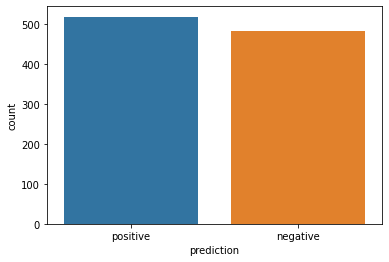

In [ ]:
# Summarise class details
sns.countplot(x=Tw_test['prediction'])

In [ ]:
test_sentiment_analysis2.to_csv('/content/test_sentiment_analysis_2_Prediction.csv', index = False)
test_sentiment_analysis2.head()

,id,Tweets,Tokenised_Tweets,Lemmatised_Tweets,Tweet_without_stopwords,prediction
0,96d74cb729,Shanghai is also really exciting (precisely -...,Shanghai is also really exciting ( precisely -...,Shanghai is also really exciting ( precisely -...,Shanghai also really exciting (precisely -- sk...,positive
1,eee518ae67,"Recession hit Veronique Branquinho, she has to...","Recession hit Veronique Branquinho , she has t...","Recession hit Veronique Branquinho , she ha to...","Recession hit Veronique Branquinho, quit compa...",negative
2,01082688c6,happy bday!,happy bday !,happy bday !,happy bday!,positive
3,33987a8ee5,http://twitpic.com/4w75p - I like it!!,http://twitpic.com/4w75p - I like it ! !,http://twitpic.com/4w75p - I like it ! !,http://twitpic.com/4w75p - I like it!!,positive
4,726e501993,that`s great!! weee!! visitors!,that ` s great ! ! weee ! ! visitors !,that ` s great ! ! weee ! ! visitor !,that`s great!! weee!! visitors!,positive


In [ ]:
# import json

# import pandas as pd

# test_file_path = "/content/test_sentiment_analysis_2_Prediction.csv"
# df_test = pd.read_csv(test_file_path)
# df_test = df_test[["id", "prediction"]]

# data = []
# for index, row in df_test.iterrows():
#     data.append({'id': row['id'], 'prediction': row['prediction']})

# print(data[0:5])

# submission_file_path = "submission.json"
# with open(submission_file_path, 'w') as fp:
#     fp.write('\n'.join(json.dumps(i) for i in data))

[{'id': '96d74cb729', 'prediction': 'positive'}, {'id': 'eee518ae67', 'prediction': 'negative'}, {'id': '01082688c6', 'prediction': 'positive'}, {'id': '33987a8ee5', 'prediction': 'positive'}, {'id': '726e501993', 'prediction': 'positive'}]


In [ ]:
test_sentiment_analysis_2_Prediction = "/content/test_sentiment_analysis_2_Prediction.csv"
test_sentiment_analysis_Prediction = "/content/test_sentiment_analysis_Prediction.csv"
plt.plot(Tw_test[test_sentiment_analysis_Prediction],Tw_test[test_sentiment_analysis_2_Prediction])
plt.show()

KeyError: ignored